# **Home Exercise on Named Entity Recognition**
Implement a **Recurrent Neural Network model (Bidirectional LSTM-CRF Models for Sequence Tagging)** to extract named entities from text, entity labels are encoded using the BIO notation, where each entity label is assigned a **B** (Beginning) or **I** (Inside) tag. The **B-** tag indicates the beginning of an entity, while the **I-** tag marks words inside the same entity.

These tags help identify multi-word entities. For example, in the phrase **"World War II"**, the labels would be: **(B-eve, I-eve, I-eve)**. Words that do not belong to any entity are labeled as **O (Outside)**.

* Data: [Annotated GMB Corpus](https://www.kaggle.com/datasets/shoumikgoswami/annotated-gmb-corpus?select=GMB_dataset.txt)(**the last 10% of sentences serve as the test set**).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import shutil, sys, zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from datetime import datetime
import datetime
from helper_functions import *

print(f"The last time this notebook was run is: {datetime.datetime.now().strftime('%H:%M:%S %d/%m/%')}")


The last time this notebook was run is: 17:59:27 28/11/%


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shoumikgoswami/annotated-gmb-corpus")

print("Path to dataset files:", path)

Path to dataset files: /home/dikhang/.cache/kagglehub/datasets/shoumikgoswami/annotated-gmb-corpus/versions/1


In [15]:
# src_dir = "/home/dikhang/.cache/kagglehub/datasets/shoumikgoswami/annotated-gmb-corpus/versions/1"
filename = "GMB_dataset.txt"

# full_path = os.path.join(src_dir, filename)
# file_path = move_file(full_path, "./data")
data_dir = "./data"
file_path = os.path.join(data_dir, filename)
print("Moved to:", file_path)


Moved to: ./data/GMB_dataset.txt


## Loading to Dataset class by DataLoader

In [ ]:
import random
from collections import Counter, defaultdict
from typing import List, Tuple

START_TAG = "<START>"
STOP_TAG = "<STOP>"
PAD_TAG = "<PAD>"
UNK_TOKEN = "<UNK>"

In [17]:
def read_text(path) -> Tuple[List[List[str]], List[List[str]]]:
    sentences, tags = [], []
    words, labels = [], []
    
    with open(path, 'r', encoding='utf8', errors='replace') as f:
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(words)
                    tags.append(labels)
                    words, labels = [], []
                continue
            parts = line.split()
            if len(parts) == 1:
                token = parts[0]
                tag = "O"
            else:
                token = parts[0]
                tag = parts[-1]
            words.append(token)
            labels.append(tag)
    if words:
        sentences.append(words)
        tags.append(labels)
    return sentences, tags
       

In [18]:
all_sentences, all_tags = read_text(file_path)

print(f"Number of sentences: {len(all_sentences)}")

Number of sentences: 1


### Build vocabularies class

In [21]:
class Vocabulary:
    
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.tag2idx = {"<PAD>": 0, "<START>": 1, "<STOP>": 2}
        self.idx2tag = {}
        
    def build_vocab(self, sentences: List[List[str]], tags: List[List[str]]):
        for sentence in sentences:
            for word in sentence:
                if word not in self.word2idx:
                    self.word2idx[word] = len(self.word2idx)
                    
        for tag_seq in tags:
            for tag in tag_seq:
                if tag not in self.tag2idx:
                    self.tag2idx[tag] = len(self.tag2idx)
                    
        self.idx2tag = {v : k for k, v in self.tag2idx.items()}

### Build the Dataset class

In [22]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

class NERDataset(Dataset):
    def __init__(self, sentences, tags, vocab):
        self.sentences = sentences
        self.tags = tags
        self.vocab = vocab

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        s = [self.vocab.word2idx.get(w, self.vocab.word2idx["<UNK>"]) for w in self.sentences[idx]]
        t = [self.vocab.tag2idx[t] for t in self.tags[idx]]
        return torch.tensor(s, dtype=torch.long), torch.tensor(t, dtype=torch.long)

In [23]:
def collate_fn(batch):
    sentences, tags = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences])
    s_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    t_padded = pad_sequence(tags, batch_first=True, padding_value=0)
    return s_padded, t_padded, lengths

## Build the BiLSTM-CRF model

In [25]:
def log_sum_exp(smat):
    vmax = smat.max(dim=1, keepdim=True).values
    return (smat - vmax).exp().sum(axis=1, keepdim=True).log() + vmax

In [26]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        self.transitions.data[tag_to_ix["<START>"], :] = -10000
        self.transitions.data[:, tag_to_ix["<STOP>"]] = -10000

    def _get_lstm_features(self, sentence, lengths):
        embeds = self.word_embeds(sentence)
        packed = pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        return self.hidden2tag(lstm_out)

    def _forward_alg(self, feats, masks):
        batch_size, seq_len, tag_size = feats.size()
        alpha = torch.full((batch_size, tag_size), -10000., device=feats.device)
        alpha[:, self.tag_to_ix["<START>"]] = 0.

        for t in range(seq_len):
            mask_t = masks[:, t].unsqueeze(1)
            emit_scores = feats[:, t, :]
            score = alpha.unsqueeze(1) + self.transitions.unsqueeze(0) + emit_scores.unsqueeze(2)
            alpha = (torch.logsumexp(score, dim=2) * mask_t) + (alpha * (1 - mask_t))

        return torch.logsumexp(alpha + self.transitions[self.tag_to_ix["<STOP>"]].unsqueeze(0), dim=1)

    def _score_sentence(self, feats, tags, masks):
        batch_size, seq_len, _ = feats.size()
        score = torch.zeros(batch_size, device=feats.device)
        start_tags = torch.full((batch_size,), self.tag_to_ix["<START>"], dtype=torch.long, device=feats.device)
        tags = torch.cat([start_tags.unsqueeze(1), tags], dim=1)

        for t in range(seq_len):
            mask_t = masks[:, t]
            emit = torch.gather(feats[:, t], 1, tags[:, t+1].unsqueeze(1)).squeeze()
            trans = self.transitions[tags[:, t+1], tags[:, t]]
            score += (emit + trans) * mask_t
            
        last_tags = torch.gather(tags, 1, masks.sum(1).long().unsqueeze(1)).squeeze()
        score += self.transitions[self.tag_to_ix["<STOP>"], last_tags]
        return score

    def neg_log_likelihood(self, sentences, tags, lengths):
        feats = self._get_lstm_features(sentences, lengths)
        masks = torch.arange(sentences.size(1), device=sentences.device)[None, :] < lengths[:, None].to(sentences.device)
        masks = masks.float()
        return torch.mean(self._forward_alg(feats, masks) - self._score_sentence(feats, tags, masks))

    def forward(self, sentences, lengths):
        feats = self._get_lstm_features(sentences, lengths)
        batch_size, seq_len, tag_size = feats.size()
        masks = torch.arange(seq_len, device=sentences.device)[None, :] < lengths[:, None].to(sentences.device)
        masks = masks.float()
        
        path_score = torch.full((batch_size, tag_size), -10000., device=sentences.device)
        path_score[:, self.tag_to_ix["<START>"]] = 0.
        backpointers = []

        for t in range(seq_len):
            mask_t = masks[:, t].unsqueeze(1)
            score = path_score.unsqueeze(1) + self.transitions.unsqueeze(0)
            best_score, best_idx = torch.max(score, dim=2)
            path_score = (best_score + feats[:, t]) * mask_t + path_score * (1 - mask_t)
            backpointers.append(best_idx)

        best_score, best_final_tag = torch.max(path_score + self.transitions[self.tag_to_ix["<STOP>"]].unsqueeze(0), dim=1)
        
        best_paths = []
        for b in range(batch_size):
            path = [best_final_tag[b].item()]
            length = int(lengths[b].item())
            for t in range(length - 1, -1, -1):
                path.append(backpointers[t][b][path[-1]].item())
            best_paths.append(path[::-1][1:])
        return best_paths

## Training the model

In [44]:
### Configurate the hyperparameters
BATCH_SIZE = 64
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
def evaluate(model, loader, vocab):
    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0
    
    with torch.no_grad():
        for s, t, l in loader:
            s, t = s.to(DEVICE), t.to(DEVICE)
            total_loss += model.neg_log_likelihood(s, t, l.cpu()).item()
            preds = model(s, l.cpu())
            for i, p in enumerate(preds):
                length = int(l[i])
                all_preds.extend([vocab.idx2tag[x] for x in p])
                all_targets.extend([vocab.idx2tag[x] for x in t[i][:length].tolist()])
    
    # 1. Tính Token Accuracy
    acc = accuracy_score(all_targets, all_preds)
    
    # 2. Tính F1-Score
    labels_no_O = [tag for tag in vocab.tag2idx.keys() if tag not in ["<PAD>", "<START>", "<STOP>", "O"]]
    f1 = f1_score(all_targets, all_preds, labels=labels_no_O, average='micro', zero_division=0)
    
    return total_loss / len(loader), f1, acc, all_targets, all_preds

def train_model(model, train_loader, val_loader, optimizer, scheduler, vocab, patience=5):

    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_acc': []}
    best_loss = float('inf')
    trigger_times = 0
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        for s, t, l in train_loader:
            s, t = s.to(DEVICE), t.to(DEVICE)
            model.zero_grad()
            loss = model.neg_log_likelihood(s, t, l.cpu())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        val_loss, val_f1, val_acc, _, _ = evaluate(model, val_loader, vocab)
        
        # Scheduler step
        scheduler.step(val_loss)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_acc'].append(val_acc) # Lưu accuracy
        
        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
        
        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"[STOP] Early stopping at epoch {epoch+1}")
                break
    return history

## Evaluate the model

In [59]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss History'); plt.legend(); plt.grid(True)
    
    # 2. F1-score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_f1'], 'g-', label='Val Entity F1')
    plt.title('Validation F1-Score (Entities)'); plt.legend(); plt.grid(True)

    # 3. Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_acc'], 'm-', label='Val Token Accuracy')
    plt.title('Validation Token Accuracy'); plt.legend(); plt.grid(True)
    
    plt.show()

Running on: cpu
Columns in file: Index(['Unnamed: 0', 'Sentence #', 'Word', 'POS', 'Tag'], dtype='object')


/tmp/ipykernel_2852/4227761253.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = data.groupby("Sentence #").apply(getter)


Total Sentences: 2999
Vocab: 7766 words, 20 tags

--- Starting Training ---
Epoch 01 | Train Loss: 33.9088 | Val Loss: 18.3150 | Val F1: 0.0000 | Val Acc: 0.8447
Epoch 02 | Train Loss: 15.0808 | Val Loss: 15.1707 | Val F1: 0.0042 | Val Acc: 0.8448
Epoch 03 | Train Loss: 12.5327 | Val Loss: 12.9039 | Val F1: 0.0962 | Val Acc: 0.8515
Epoch 04 | Train Loss: 10.2319 | Val Loss: 10.8597 | Val F1: 0.3113 | Val Acc: 0.8715
Epoch 05 | Train Loss: 8.3965 | Val Loss: 9.5278 | Val F1: 0.4281 | Val Acc: 0.8871
Epoch 06 | Train Loss: 7.0035 | Val Loss: 8.4254 | Val F1: 0.5135 | Val Acc: 0.9010
Epoch 07 | Train Loss: 5.9105 | Val Loss: 7.9330 | Val F1: 0.5559 | Val Acc: 0.9056
Epoch 08 | Train Loss: 5.0462 | Val Loss: 7.1944 | Val F1: 0.5773 | Val Acc: 0.9112
Epoch 09 | Train Loss: 4.3272 | Val Loss: 6.9689 | Val F1: 0.5876 | Val Acc: 0.9114
Epoch 10 | Train Loss: 3.7293 | Val Loss: 6.7456 | Val F1: 0.6019 | Val Acc: 0.9099
Epoch 11 | Train Loss: 3.2088 | Val Loss: 6.4252 | Val F1: 0.6036 | Val Acc:

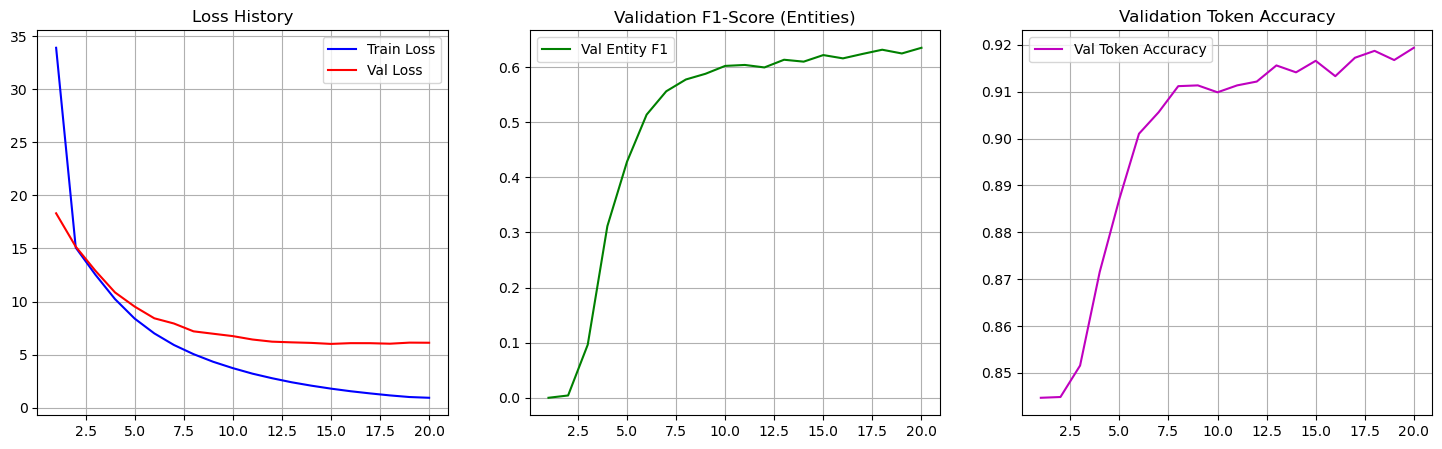

In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import time

if __name__ == "__main__":
    print(f"Running on: {DEVICE}")
    
    # 1. Load & Split Data
    all_sentences, all_tags = read_text(file_path)
    print(f"Total Sentences: {len(all_sentences)}")

    test_split = int(len(all_sentences) * 0.9)
    train_full_s, test_s = all_sentences[:test_split], all_sentences[test_split:]
    train_full_t, test_t = all_tags[:test_split], all_tags[test_split:]
    
    val_split = int(len(train_full_s) * 0.9)
    train_s, val_s = train_full_s[:val_split], train_full_s[val_split:]
    train_t, val_t = train_full_t[:val_split], train_full_t[val_split:]

    # 2. Build Vocab & Loaders
    vocab = Vocabulary()
    vocab.build_vocab(train_s, train_t)
    print(f"Vocab: {len(vocab.word2idx)} words, {len(vocab.tag2idx)} tags")

    train_loader = DataLoader(NERDataset(train_s, train_t, vocab), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(NERDataset(val_s, val_t, vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(NERDataset(test_s, test_t, vocab), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # 3. Train
    model = BiLSTM_CRF(len(vocab.word2idx), vocab.tag2idx, EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    print("\n--- Starting Training ---")
    start_time = time.time()
    history = train_model(model, train_loader, val_loader, optimizer, scheduler, vocab, patience=5)
    print(f"Training Time: {time.time() - start_time:.0f}s")

    # 4. Plot Charts 
    plot_history(history)

In [62]:

print("   FINAL EVALUATION REPORT   ")
print("="*30)
    
model.load_state_dict(torch.load('best_model.pth'))
    
test_loss, test_f1, test_acc, targets, preds = evaluate(model, test_loader, vocab)
    
print(f"Test loss:     {test_loss:.4f}")
print(f"Token accuracy: {test_acc*100:.2f}%")
print(f"Entity F1-Score: {test_f1*100:.2f}%")
    
print("-" * 60)
labels_no_O = [tag for tag in vocab.tag2idx.keys() if tag not in ["<PAD>", "<START>", "<STOP>", "O"]]
print(classification_report(targets, preds, labels=labels_no_O, zero_division=0))

   FINAL EVALUATION REPORT   
Test loss:     5.3980
Token accuracy: 92.03%
Entity F1-Score: 63.90%
------------------------------------------------------------
              precision    recall  f1-score   support

       B-geo       0.85      0.54      0.66       250
       B-gpe       0.70      0.75      0.73        93
       B-per       0.59      0.66      0.62       144
       I-geo       0.67      0.47      0.55        34
       B-org       0.47      0.55      0.51       101
       I-org       0.66      0.51      0.58        96
       B-tim       0.89      0.74      0.81       113
       B-art       0.00      0.00      0.00         0
       I-art       0.00      0.00      0.00         0
       I-per       0.57      0.83      0.67       127
       I-gpe       0.00      0.00      0.00         2
       I-tim       0.78      0.22      0.34        32
       B-nat       0.00      0.00      0.00         1
       B-eve       0.00      0.00      0.00         4
       I-eve       0.00      

In [ ]:
def visualize_prediction(model, sentence, vocab, device):
    model.eval()
    tokens = sentence.strip().split()
    idxs = [vocab.word2idx.get(w, vocab.word2idx["<UNK>"]) for w in tokens]
    
    s_tensor = torch.tensor([idxs], dtype=torch.long).to(device)
    lengths = torch.tensor([len(idxs)], dtype=torch.long)
    
    with torch.no_grad():
        pred_idxs = model(s_tensor, lengths.cpu())[0]
    
    pred_tags = [vocab.idx2tag[i] for i in pred_idxs]
    
    print(f"\nSentence: {sentence}")
    print("-" * 50)
    print(f"{'WORD':<15} {'PREDICTED TAG':<15}")
    print("-" * 50)
    
    for word, tag in zip(tokens, pred_tags):
        if tag != 'O':
            print(f"{word:<15} {tag:<15} <--- Entity Found")
        else:
            print(f"{word:<15} {tag:<15}")

visualize_prediction(model, "We travelled to London last Friday .", vocab, DEVICE)
visualize_prediction(model, "Steve Jobs founded Apple in California .", vocab, DEVICE)
visualize_prediction(model, "The World Health Organization is huge .", vocab, DEVICE)


Sentence: We travelled to London last Friday .
--------------------------------------------------
WORD            PREDICTED TAG  
--------------------------------------------------
We              B-per           <--- Entity Found
travelled       I-per           <--- Entity Found
to              O              
London          B-geo           <--- Entity Found
last            O              
Friday          B-tim           <--- Entity Found
.               O              

Sentence: Steve Jobs founded Apple in California .
--------------------------------------------------
WORD            PREDICTED TAG  
--------------------------------------------------
Steve           O              
Jobs            O              
founded         O              
Apple           O              
in              O              
California      B-geo           <--- Entity Found
.               O              

Sentence: The World Health Organization is huge .
-------------------------------------------